非常感谢您学习到这里，如果有时间的话希望能帮我填一个：[教程反馈](https://www.wjx.cn/jq/61058547.aspx)

在这个教程中，我想用taxi gps数据计算每一辆出租车在一天内的收入。如果能够成功计算，再看看高收入的出租车司机的行为，就可以分析出来：  
>毕业以后要是失业了，怎么样开出租车才能赚更多的钱！升职加薪赢取白富美就在明天！

提供的基础数据是：
<div class="alert alert-info"><h2>提供的基础数据是：</h2><p>   
    数据：<br>  
    1.出租车原始GPS数据<br>  

 </p></div>
 
 <div class="alert alert-info"><h2>深圳出租车计价规则：</h2><p>   
(一)起步价：首2公里11.00元;<br>  
(二)里程价：超过2公里部分，每公里2.40元;<br>  
(三)返空费：每天的23时至次日凌晨6时，超过25公里部分，每公里按上述里程价的30%加收返空费：<br>  
(四)夜间附加费：夜间起步价16元，每天的23时至次日凌晨6时，按上述起步价和里程价的20%加收夜间附加费;<br>  
(五)候时费：每分钟0.80元;<br>  
(六)大件行李费;体积超过0.2立方米、重量超过20公斤的大件行李，每件0.50元。<br>  
 </p></div>  
 
 
在计算的时候，我们可以以订单开始的时间判定夜间还是日间。另外，规则（六）也考虑不了

# 如何做一个优雅的出租车手？

上一节我们计算了每个订单的价格，这一节来进行一些分析

In [2]:
import pandas as pd

In [3]:
table5 = pd.read_csv(r'data-sample/taxi-price.csv')
table5.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,interval,isnight,起步价,里程价,返空费,夜间附加费,候时费,price
0,1.0,22334,2020-01-20 00:01:04,114.111130,22.576750,0,2020-01-20 00:17:58,114.084915,22.540850,6785.602632,180.0,True,16,11.485446,-0.0,2.297089,2.400000,32.182536
1,2.0,22334,2020-01-20 00:18:16,114.084915,22.540850,0,2020-01-20 00:44:47,114.056236,22.633383,15698.063306,309.0,True,16,32.875352,-0.0,6.575070,4.120000,59.570422
2,3.0,22334,2020-01-20 00:44:52,114.056236,22.633383,0,2020-01-20 02:46:52,114.093498,22.554382,12508.941904,140.0,True,16,25.221461,-0.0,5.044292,1.866667,48.132419
3,4.0,22334,2020-01-20 02:47:04,114.093536,22.554382,0,2020-01-20 04:13:57,114.052299,22.604366,15144.760499,100.0,True,16,31.547425,-0.0,6.309485,1.333333,55.190244
4,5.0,22334,2020-01-20 04:23:07,114.052216,22.602118,0,2020-01-20 06:41:19,114.067886,22.521299,15458.541238,60.0,True,16,32.300499,-0.0,6.460100,0.800000,55.560599


做一些预处理操作，剔除不合理数据

In [4]:
#计算订单用时
table5['interval'] = (pd.to_datetime(table5['Etime']) -pd.to_datetime(table5['Stime'])).apply(lambda r:r.seconds)
#运营车速
table5['speed'] = (table5['distance']/table5['interval'])*3.6
#运营车速太快的筛掉
table5 = table5[table5['speed']<80].copy()
#每分钟平均收入多少
table5['price_per_minutes'] = table5['price']/(table5['interval']/60)

In [5]:
len(table5)

10592

## 出租车一天收入多少

In [6]:
#集计收入
df0 = table5.groupby('VehicleNum')['price'].sum()

然而这里我们考虑的只是订单的收入，还需要考虑油费，跑的距离越长，油费就越高

In [8]:
#定义计算路径长度函数
from math import pi
import numpy as np

def getdistance(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）输入为DataFrame的列
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(lambda r:r*pi/180, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(a**0.5) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r * 1000

In [39]:
#计算出租车行驶的距离
#读取原始数据
data = pd.read_csv(r'data-sample/TaxiData-Sample',header = None)
#给数据命名列
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']

data = data.sort_values(by = ['VehicleNum', 'Stime'])

#将时间字符串转换为pd的时间格式，后面可以轻松的做加减
data['Stime'] = pd.to_datetime(data['Stime'])

########清洗OpenStatus异常的数据#########
print('清洗OpenStatus异常的数据前',len(data))
data = data[-((data['OpenStatus'].shift(-1) == data['OpenStatus'].shift())&
(data['OpenStatus'].shift(-1) != data['OpenStatus'])&
(data['VehicleNum'].shift(-1) == data['VehicleNum'].shift())&
(data['VehicleNum'].shift(-1) == data['VehicleNum']))]
print('清洗OpenStatus异常的数据后',len(data))
#######################################

#定义计算路径长度
data['Lng1'] = data['Lng'].shift(-1)
data['Lat1'] = data['Lat'].shift(-1)
data['Stime1'] = data['Stime'].shift(-1)
data['VehicleNum1'] = data['VehicleNum'].shift(-1)


#计算每个点与下一个点的距离
lon1 = data['Lng']
lat1 = data['Lat']
lon2 = data['Lng1']
lat2 = data['Lat1']
data['distance'] = getdistance(lon1, lat1, lon2, lat2)

#计算每个点与下一个点的时间差
data['interval'] = (data['Stime1']-data['Stime']).apply(lambda r:r.seconds)

#速度
data['speed'] = (data['distance']/data['interval'])*3.6

data = data[data['VehicleNum1'] == data['VehicleNum']]

#计算每辆车的驾驶距离
disagg = data.groupby(['VehicleNum'])['distance'].sum().reset_index()
disagg.head(5)
disagg
#小汽车每百公里大概在35-75元左右不等，我们统一定为每公里0.75元油费
disagg['cost'] = (disagg['distance']/1000)*0.75
disagg

清洗OpenStatus异常的数据前 1601307
清洗OpenStatus异常的数据后 1598866


,VehicleNum,distance,cost
0,22271,283059.608529,212.294706
1,22334,440004.732500,330.003549
2,22396,609776.169354,457.332127
3,22413,318614.255089,238.960691
4,22437,360716.971788,270.537729
...,...,...,...
495,36839,460925.748051,345.694311
496,36860,473907.191422,355.430394
497,36895,463369.457189,347.527093
498,36924,353986.178173,265.489634


In [10]:
df0 = pd.merge(df0.reset_index(),disagg,on = 'VehicleNum')
df0['income'] = df0['price']-df0['cost']
df0.head(5)

,VehicleNum,price,distance,cost,income
0,22334,1256.932221,4.400047e+05,330.003549,926.928671
1,22396,515.061210,6.097762e+05,457.332127,57.729083
2,22437,907.708227,3.607170e+05,270.537729,637.170498
3,22449,1107.521722,1.144476e+06,858.356661,249.165061
4,22455,1510.868019,5.227240e+05,392.042966,1118.825053


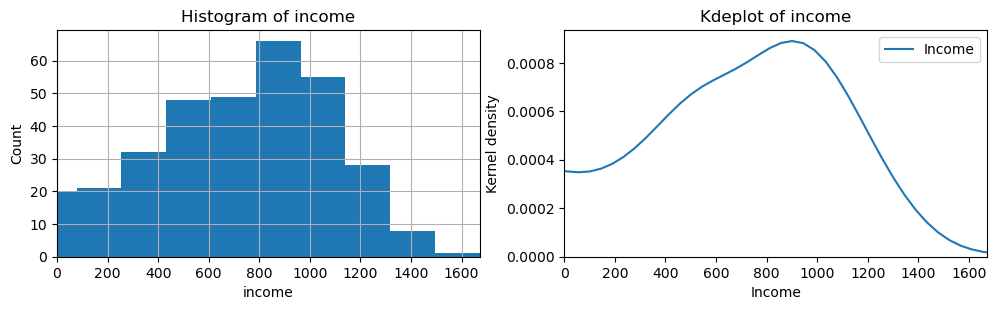

In [12]:
#用pandas自带hist绘制直方图
import matplotlib.pyplot as plt
fig     = plt.figure(1,(12,3),dpi = 100)    
ax1      = plt.subplot(121)
plt.sca(ax1)
df0['income'].hist(ax = ax1,bins = 20)
plt.ylabel('Count')
plt.xlabel('income')
plt.xlim(0,df0['income'].quantile(1))
plt.title('Histogram of income')

import seaborn as sns
#用seaborn绘制kdeplot核密度分布
ax2      = plt.subplot(122)
plt.sca(ax2)
sns.kdeplot(df0['income'],ax = ax2,label = 'Income')
plt.ylabel('Kernel density')
plt.xlabel('Income')
plt.xlim(0,df0['income'].quantile(1))
plt.title('Kdeplot of income')
plt.show()

## 去哪接客挣钱多？

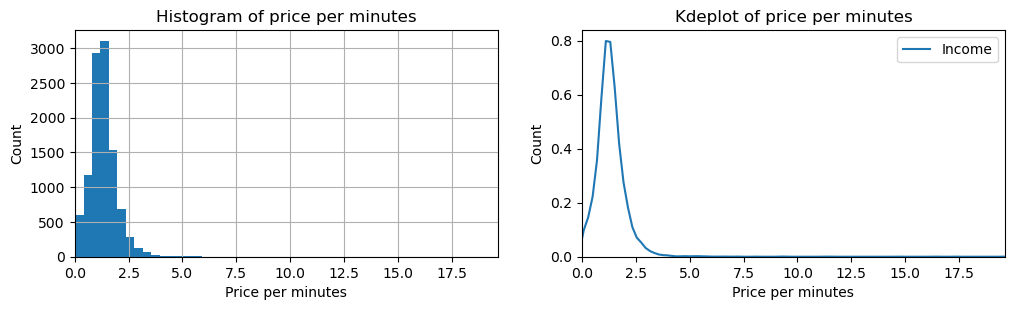

In [13]:

#用pandas自带hist绘制直方图
import matplotlib.pyplot as plt
fig     = plt.figure(1,(12,3),dpi = 100)    
ax1      = plt.subplot(121)
plt.sca(ax1)
table5['price_per_minutes'].hist(ax = ax1,bins = 50)
plt.ylabel('Count')
plt.xlabel('Price per minutes')
plt.title('Histogram of price per minutes')
plt.xlim(0,table5['price_per_minutes'].max())

import seaborn as sns
#用seaborn绘制kdeplot核密度分布
ax2      = plt.subplot(122)
plt.sca(ax2)
sns.kdeplot(table5['price_per_minutes'],ax = ax2,label = 'Income')
plt.ylabel('Count')
plt.xlabel('Price per minutes')

plt.xlim(0,table5['price_per_minutes'].quantile(1))
plt.title('Kdeplot of price per minutes')
plt.show()

绘制一下热力图，看看在出租车订单起点处平均价格的空间分布

In [14]:
#栅格数据
#读取shapefile文件
import geopandas
shp = r'shapefile/grid/grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')


In [15]:
#计算每个格子的平均收入
data = table5[['Lng','Lat','price_per_minutes']].copy()


#经纬度小数点保留三位小数
import math
#划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748

latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 500;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')

data = data.groupby(['LONCOL','LATCOL'])['price_per_minutes'].mean().reset_index()

data.head(5)

,LONCOL,LATCOL,price_per_minutes
0,6,52,0.782425
1,8,52,2.444964
2,8,54,3.461804
3,8,57,1.895827
4,8,80,1.105671


In [16]:
#将集计的结果与栅格的geopandas执行merge操作
gridtoplot = pd.merge(grid,data,on = ['LONCOL','LATCOL'])
gridtoplot.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry,price_per_minutes
0,6,52,113.778739,22.679412,"POLYGON ((113.776303070446 22.67716386552757, ...",0.782425
1,8,52,113.788485,22.679412,"POLYGON ((113.7860482986245 22.67716386552757,...",2.444964
2,8,54,113.788485,22.688405,"POLYGON ((113.7860482986245 22.68615707594042,...",3.461804
3,8,57,113.788485,22.701895,"POLYGON ((113.7860482986245 22.69964689155968,...",1.895827
4,9,52,113.793357,22.679412,"POLYGON ((113.7909209127137 22.67716386552757,...",0.450346


In [21]:
import imp
imp.reload(plot_map)

<module 'plot_map' from 'C:\\pythonscript\\2020\\pygeo-tutorial\\plot_map.py'>

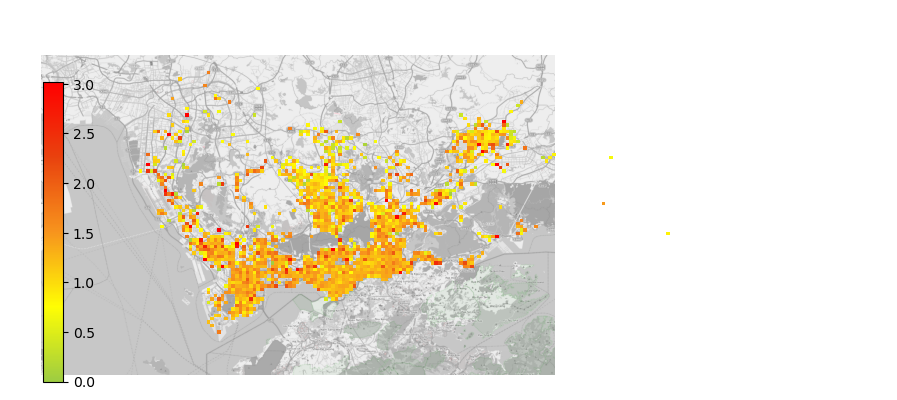

In [26]:
#绘制地理分布图
fig     = plt.figure(1,(10,10),dpi = 100)  
ax      = plt.subplot(111)
plt.sca(ax)
fig.tight_layout(rect = (0.05,0.1,1,0.9))

bounds = [113.7, 22.42, 114.3, 22.8]
#绘制地图
import plot_map
plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#设置colormap的数据
import matplotlib
vmax = gridtoplot['price_per_minutes'].quantile(0.99)
#设定一个标准化的工具，设定OD的colormap最大最小值，他的作用是norm(count)就会将count标准化到0-1的范围内
norm = matplotlib.colors.Normalize(vmin=0,vmax=vmax)

#设定colormap的颜色
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('cmap', ['#9DCC42','#FFFE03','#F7941D','#E9420E','#FF0000'], 256)



#将gridtoplot这个geodataframe进行绘制
#提示：用gridtoplot.plot，设定里面的参数是column = 'count'，以count这一列来绘制。参数cmap = cmap设定它的颜色
gridtoplot.plot(ax = ax,column = 'price_per_minutes',cmap = cmap,vmax = vmax,vmin = 0)


#不显示坐标轴
plt.axis('off')    

#然后要把镜头调整回到深圳地图那，不然镜头就在imshow那里了
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)
#绘制colorbar
plt.imshow([[0,vmax]], cmap=cmap)
#设定colorbar的大小和位置
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)





plt.show()

## 什么时候接客订单多？什么时候接客单笔订单价格高？

In [27]:
table5['Shour'] = pd.to_datetime(table5['Stime']).apply(lambda r:r.hour)

In [28]:
# 每小时订单数
df1 = table5.groupby(['Shour'])['VehicleNum'].count().reset_index()
# 每小时平均订单价格
df2 = table5.groupby(['Shour'])['price_per_minutes'].mean().reset_index()


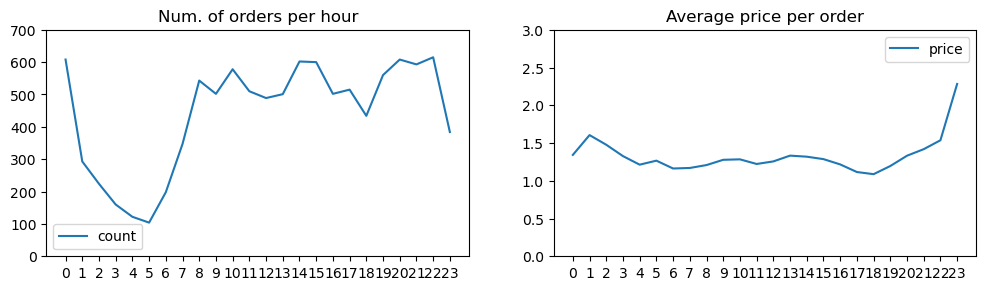

In [29]:
fig     = plt.figure(1,(12,3),dpi = 100)    

#创建一个子图
ax1      = plt.subplot(121)
plt.sca(ax1)

#绘制折线图
plt.plot(df1['Shour'],df1['VehicleNum'],label = 'count')
plt.legend()
plt.title('Num. of orders per hour')
plt.xticks(range(24),df1['Shour'])
plt.ylim(0,700)
#创建另一个子图
ax2      = plt.subplot(122)
plt.sca(ax2)

#绘制折线图
plt.plot(df1['Shour'],df2['price_per_minutes'],label = 'price')
plt.legend()
plt.title('Average price per order')
plt.xticks(range(24),df1['Shour'])
plt.ylim(0,3)
plt.show()

## 收入最高的车手与收入中等的车手，挣钱方式有什么不一样吗

抽取高收入车手（收入排名前20%），中等收入车手（收入排名40%-60%）

In [30]:
highincome = df0[df0['income']>df0['income'].quantile(0.8)]['VehicleNum']
len(highincome)

74

In [31]:
midincome = df0[(df0['income']>df0['income'].quantile(0.4))&(df0['income']<df0['income'].quantile(0.6))]['VehicleNum']
len(midincome)

73

In [32]:
#提取两组车手的订单
highincome_order = pd.merge(table5,highincome,on = 'VehicleNum')
midincome_order = pd.merge(table5,midincome,on = 'VehicleNum')

In [33]:
highincome_order.head(5)

,orderid,VehicleNum,Stime,Lng,Lat,isd,Etime,ELng,ELat,distance,...,isnight,起步价,里程价,返空费,夜间附加费,候时费,price,speed,price_per_minutes,Shour
0,133.0,22455,2020-01-20 00:00:02,113.909340,22.485928,0,2020-01-20 00:57:56,114.098518,22.579077,33896.340821,...,True,16,76.551218,6.405365,15.310244,1.906667,116.173494,35.125742,2.006451,0
1,135.0,22455,2020-01-20 01:36:34,114.165077,22.564360,0,2020-01-20 01:49:19,114.122047,22.569462,8909.947881,...,True,16,16.583875,-0.000000,3.316775,0.133333,36.033983,41.929166,2.826195,1
2,136.0,22455,2020-01-20 01:49:34,114.121758,22.569315,0,2020-01-20 02:25:27,114.124191,22.552382,11206.099299,...,True,16,22.094638,-0.000000,4.418928,0.586667,43.100233,18.737556,1.201121,1
3,137.0,22455,2020-01-20 02:25:34,114.124168,22.552378,0,2020-01-20 02:41:45,114.064377,22.531965,6973.034435,...,True,16,11.935283,-0.000000,2.387057,0.386667,30.709006,25.852651,1.897570,2
4,139.0,22455,2020-01-20 02:49:34,114.042885,22.527573,0,2020-01-20 04:00:05,114.039429,22.560907,19407.948504,...,True,16,41.779076,-0.000000,8.355815,1.013333,67.148225,16.513499,0.952232,2


观察高收入中收入群体每天的订单数量，与订单每分钟收入分布情况

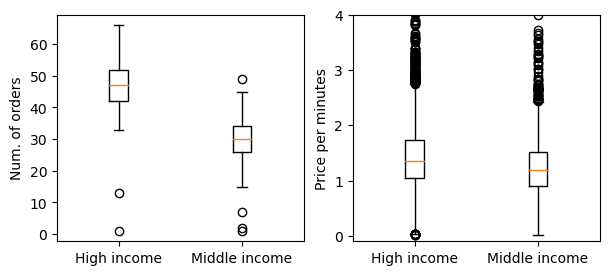

In [35]:
#高收入中收入群体每天的订单数量
fig     = plt.figure(1,(7,3),dpi = 100)    
ax      = plt.subplot(121)
plt.sca(ax)
plt.boxplot([highincome_order.groupby('VehicleNum')['orderid'].count(),
midincome_order.groupby('VehicleNum')['orderid'].count()])
plt.xticks([1,2],['High income','Middle income'])
plt.ylabel('Num. of orders')


#订单每分钟收入分布情况
  
ax      = plt.subplot(122)
plt.sca(ax)
plt.boxplot([highincome_order['price_per_minutes'],
midincome_order['price_per_minutes']])
plt.xticks([1,2],['High income','Middle income'])
plt.ylim(-0.1,4)
plt.ylabel('Price per minutes')
plt.show()


上左图可以看到，高收入车手每日接单数量说比中收入车手多的，也就是，高收入主要靠勤奋  
上右图可看到，高收入车手的订单的每分钟平均收入要稍微比中收入车手高  
也就是说，高收入车手靠的不仅仅是勤奋  
那么，高收入车手接的单为什么会稍微贵一点呢？猜想可能的原因有两种  

>1.高收入车手每天非常勤奋，半夜也出来接单，这样就比较贵  
2.高收入车手存在拒载，或者只在特定地方接单，避免接到便宜的单  


## 具体一点，到底在哪里存在差距？

### 高收入者比中收入者勤奋吗

计算高收入群体和中收入群体开车总路程，空驶总路程，载客总路程

In [40]:
#计算每辆车的空驶距离和载客距离
disagg = data.groupby(['VehicleNum','OpenStatus'])['distance'].sum().reset_index()
disagg.head(5)

,VehicleNum,OpenStatus,distance
0,22271,0,283059.608529
1,22334,0,123312.433994
2,22334,1,316692.298506
3,22396,0,448377.393501
4,22396,1,161398.775853


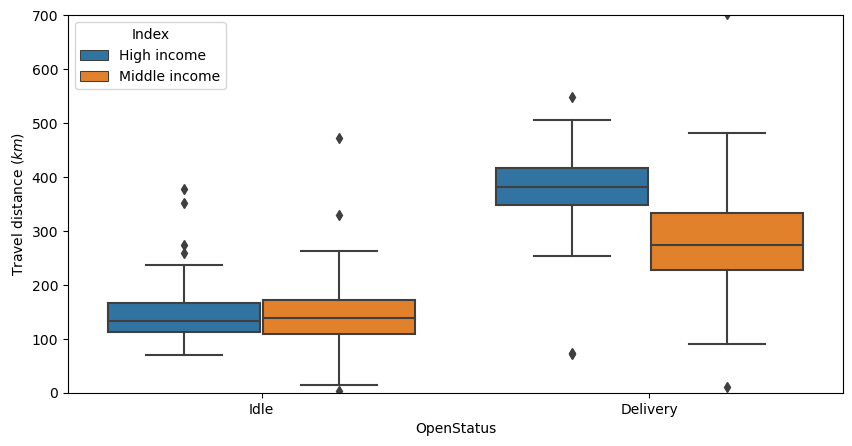

In [41]:
#整理数据到一个DataFrame中
highagg = pd.merge(highincome,disagg, on = 'VehicleNum')
highagg['Index'] = 'High income'
highagg['distance'] = highagg['distance']/1000
midagg = pd.merge(midincome,disagg, on = 'VehicleNum')
midagg['Index'] = 'Middle income'
midagg['distance'] = midagg['distance']/1000


#绘图
fig     = plt.figure(1,(10,5),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="OpenStatus", y="distance",hue="Index", data=pd.concat([highagg,midagg])
,ax = ax)
plt.ylabel('Travel distance $(km)$')
plt.ylim(0,700)
plt.xticks([0,1],['Idle','Delivery'])
plt.show()

很有意思的结论出来了：

>1.高收入者一天中空载的行驶距离与中等收入者处于同一个水平，但载客距离则明显高一个水平，也就是说，高收入者虽然开车的总距离长，但是多的距离都在载客距离上！    
2.高收入者的空驶距离和载客距离的方差都比中等收入者小，说明他们更能够控制自己每天的行驶距离，也就是，开车更稳更有技巧

### 高收入者比中收入者开车更有技巧吗

我们观察一下每小时高收入群体和中等收入群体的订单收入情况  
将高收入和中等收入的订单打上标签，合并一起，后面可以用seaborn绘制分组的boxplot

In [42]:

high_hour =  highincome_order[['Stime','price_per_minutes']].copy()
high_hour['Shour'] = pd.to_datetime(highincome_order['Stime']).apply(lambda r:r.hour)
high_hour['Index'] = 'High income'
mid_hour =  midincome_order[['Stime','price_per_minutes']].copy()
mid_hour['Shour'] = pd.to_datetime(midincome_order['Stime']).apply(lambda r:r.hour)
mid_hour['Index'] = 'Middle income'
hourdata = pd.concat([high_hour,mid_hour])

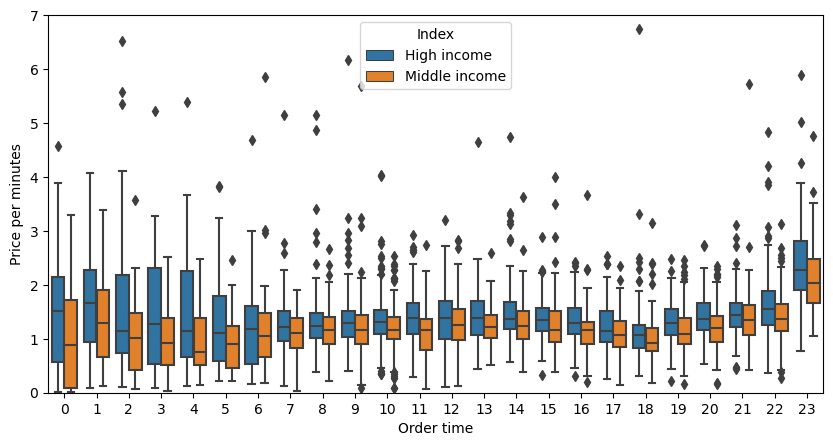

In [43]:

#绘图
fig     = plt.figure(1,(10,5),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="Shour", y="price_per_minutes",hue="Index", data=hourdata,ax = ax)
plt.ylabel('Price per minutes')
plt.xlabel('Order time')
plt.ylim(0,7)
plt.show()

统计高收入者和低收入者每小时平均的订单数量

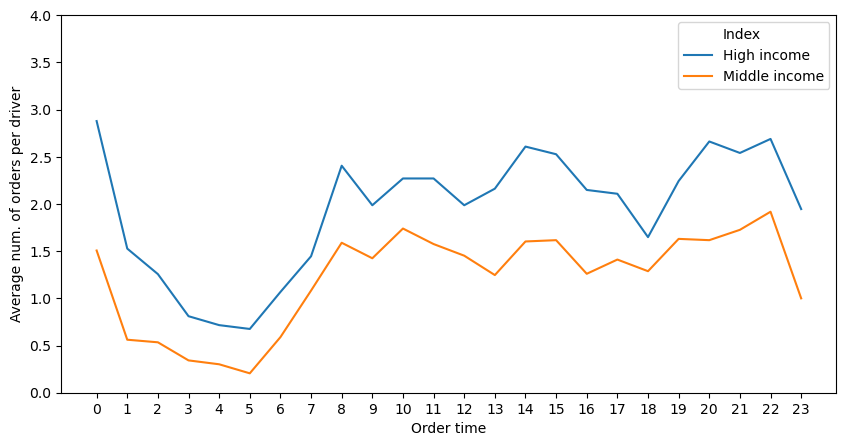

In [44]:

#统计高收入者和低收入者每小时平均的订单数量
high_hour =  (highincome_order.groupby(pd.to_datetime(highincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(highincome)).reset_index().rename(columns = {'price':'avg_count'})
high_hour['Index'] = 'High income'


mid_hour =  (midincome_order.groupby(pd.to_datetime(midincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(midincome)).reset_index().rename(columns = {'price':'avg_count'})
mid_hour['Index'] = 'Middle income'

#绘图
fig     = plt.figure(1,(10,5),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.lineplot(x="Stime", y="avg_count",hue="Index", data=pd.concat([high_hour,mid_hour]),ax = ax)
plt.ylabel('Average num. of orders per driver')
plt.xlabel('Order time')
plt.ylim(0,4)
plt.xticks(range(24),range(24))
plt.show()

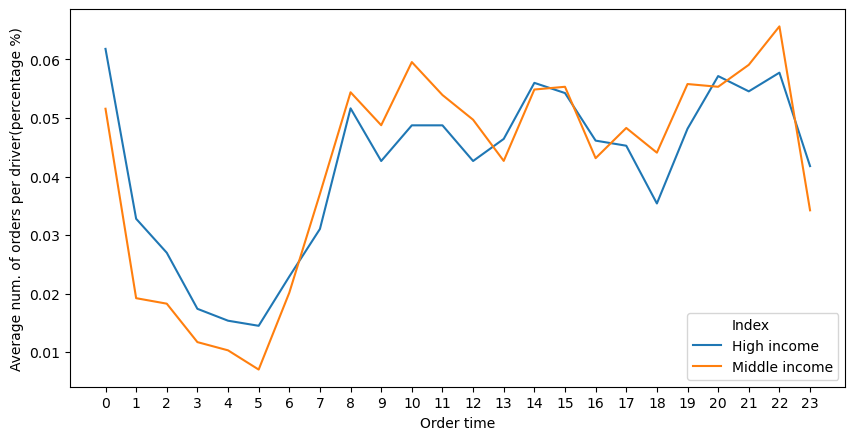

In [45]:

#统计高收入者和低收入者每小时平均的订单数量
high_hour =  (highincome_order.groupby(pd.to_datetime(highincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(highincome)).reset_index().rename(columns = {'price':'avg_count'})
high_hour['Index'] = 'High income'
high_hour['avg_count'] = high_hour['avg_count']/high_hour['avg_count'].sum()
mid_hour =  (midincome_order.groupby(pd.to_datetime(midincome_order['Stime']
                  ).apply(lambda r:r.hour))['price'].count()
/len(midincome)).reset_index().rename(columns = {'price':'avg_count'})
mid_hour['Index'] = 'Middle income'
mid_hour['avg_count'] = mid_hour['avg_count']/mid_hour['avg_count'].sum()
#绘图
fig     = plt.figure(1,(10,5),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.lineplot(x="Stime", y="avg_count",hue="Index", data=pd.concat([high_hour,mid_hour]),ax = ax)
plt.ylabel('Average num. of orders per driver(percentage %)')
plt.xlabel('Order time')
plt.xticks(range(24),range(24))
plt.show()

高收入者比中收入者更倾向于在夜间活动

统计高收入者和低收入者每小时订单的出行距离

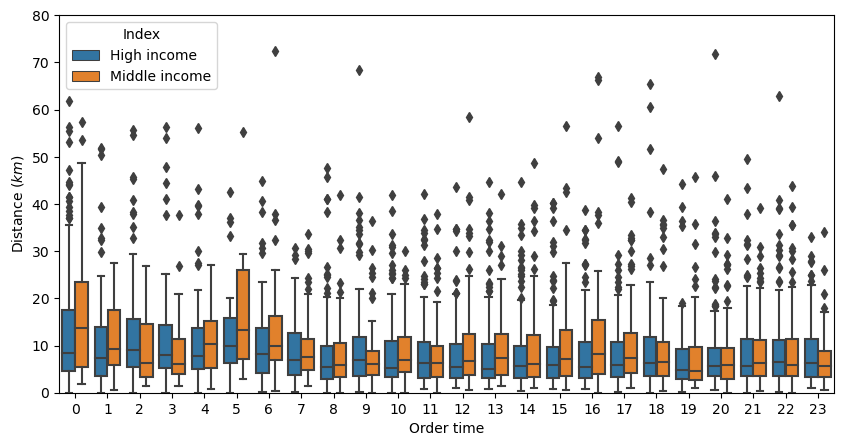

In [46]:

high_hour =  highincome_order[['Stime','distance']].copy()
high_hour['Shour'] = pd.to_datetime(highincome_order['Stime']).apply(lambda r:r.hour)
high_hour['Index'] = 'High income'
mid_hour =  midincome_order[['Stime','distance']].copy()
mid_hour['Shour'] = pd.to_datetime(midincome_order['Stime']).apply(lambda r:r.hour)
mid_hour['Index'] = 'Middle income'
hourdata = pd.concat([high_hour,mid_hour])
hourdata['distance'] = hourdata['distance']/1000

#绘图
fig     = plt.figure(1,(10,5),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="Shour", y="distance",hue="Index", data=hourdata,ax = ax)
plt.ylabel('Distance $(km)$')
plt.ylim(0,80)
plt.xlabel('Order time')
plt.show()

### 高收入者与中收入者接客地点差在哪？

In [47]:
data_list = []
#########高收入#########
#计算每个格子的平均收入
data = highincome_order[['Lng','Lat','orderid']].copy()

#删格化+集计
data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
data = data.groupby(['LONCOL','LATCOL'])['orderid'].count().reset_index()
data['orderid'] = data['orderid']/data['orderid'].sum()
data = data.rename(columns = {'orderid':'highincome_rate'})

data_list.append(data)
#######################


#########中收入#########
#计算每个格子的平均收入
data = midincome_order[['Lng','Lat','orderid']].copy()

#删格化+集计
data['LONCOL'] = ((data['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
data['LATCOL'] = ((data['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
data = data.groupby(['LONCOL','LATCOL'])['orderid'].count().reset_index()
data['orderid'] = data['orderid']/data['orderid'].sum()
data = data.rename(columns = {'orderid':'midincome_rate'})

data_list.append(data)
#######################


#将高收入和中收入的分布比例merge
data = pd.merge(data_list[0],data_list[1],on = ['LONCOL','LATCOL'],how = 'outer').fillna(0)

#计算每个格子接客数量比例差距
data['gap'] = data['highincome_rate']-data['midincome_rate']

In [48]:
#栅格数据
#读取shapefile文件
import geopandas
shp = r'shapefile/grid/grid.shp'
grid = geopandas.GeoDataFrame.from_file(shp,encoding = 'gbk')

#将集计的结果与栅格的geopandas执行merge操作
gridtoplot = pd.merge(grid,data,on = ['LONCOL','LATCOL'])
gridtoplot.head(5)

,LONCOL,LATCOL,HBLON,HBLAT,geometry,highincome_rate,midincome_rate,gap
0,10,54,113.798230,22.688405,"POLYGON ((113.7957935268029 22.68615707594042,...",0.000000,0.000469,-0.000469
1,10,55,113.798230,22.692902,"POLYGON ((113.7957935268029 22.69065368114684,...",0.000000,0.000469,-0.000469
2,11,39,113.803102,22.620956,"POLYGON ((113.8006661408921 22.61870799784407,...",0.000290,0.000000,0.000290
3,11,40,113.803102,22.625453,"POLYGON ((113.8006661408921 22.6232046030505, ...",0.001741,0.001875,-0.000135
4,11,49,113.803102,22.665922,"POLYGON ((113.8006661408921 22.6636740499083, ...",0.000000,0.000469,-0.000469


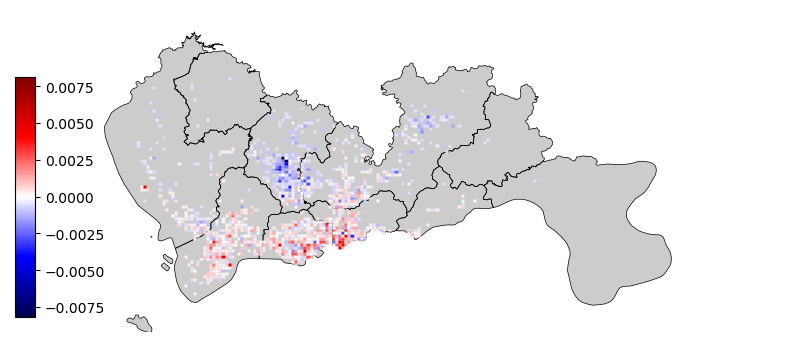

In [49]:
#绘制GIS图

fig     = plt.figure(1,(10,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
bounds = [113.6,22.4,114.8,22.9]
#绘制地图底图
import plot_map
#plot_map.plot_map(plt,bounds,zoom = 12,style = 4)

#绘制行政区划
shp = r'shapefile/sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)


#设置colormap的数据
import matplotlib
vmax = max(gridtoplot['gap'].max(),-gridtoplot['gap'].min())

#设定colormap的颜色
cmapname = 'seismic'
cmap = matplotlib.cm.get_cmap(cmapname)


#将gridtoplot这个geodataframe进行绘制
gridtoplot.plot(ax = ax,column = 'gap',edgecolor = (0,0,0,0),cmap = cmap,vmax = vmax,vmin = -vmax)


#不显示坐标轴
plt.axis('off')    

#绘制colorbar
plt.imshow([[-vmax,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()

上图，红色区域表示高收入更倾向于接客的地点，蓝色区域表示中等收入群体更倾向于接客的地点  
市中心一片红，郊区一片蓝，高收入车手更喜欢在市中心接客，尤其在罗湖福田中心区，且更多出现在一些枢纽（保安机场，罗湖火车站，皇岗口岸，深圳湾口岸等等）  

### 高收入与中收入者OD的差别

In [50]:
#栅格化代码
import math

#划定栅格划分范围
lon1 = 113.75194
lon2 = 114.624187
lat1 = 22.447837
lat2 = 22.864748
latStart = min(lat1, lat2);
lonStart = min(lon1, lon2);

#定义栅格大小(单位m)
accuracy = 2000;

#计算栅格的经纬度增加量大小▲Lon和▲Lat
deltaLon = accuracy * 360 / (2 * math.pi * 6371004 * math.cos((lat1 + lat2) * math.pi / 360));
deltaLat = accuracy * 360 / (2 * math.pi * 6371004);

In [51]:
#高收入OD统计
highincome_order['SLONCOL'] = ((highincome_order['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
highincome_order['SLATCOL'] = ((highincome_order['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
highincome_order['ELONCOL'] = ((highincome_order['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
highincome_order['ELATCOL'] = ((highincome_order['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
hod = highincome_order[['SLONCOL','SLATCOL','ELONCOL','ELATCOL']].copy()
hod['highcount'] = 1
hod = hod.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['highcount'].count().reset_index()

#中收入OD统计
midincome_order['SLONCOL'] = ((midincome_order['Lng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
midincome_order['SLATCOL'] = ((midincome_order['Lat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
midincome_order['ELONCOL'] = ((midincome_order['ELng'] - (lonStart - deltaLon / 2))/deltaLon).astype('int')
midincome_order['ELATCOL'] = ((midincome_order['ELat'] - (latStart - deltaLat / 2))/deltaLat).astype('int')
mod = midincome_order[['SLONCOL','SLATCOL','ELONCOL','ELATCOL']].copy()
mod['midcount'] = 1
mod = mod.groupby(['SLONCOL','SLATCOL','ELONCOL','ELATCOL'])['midcount'].count().reset_index()

#高收入中收入OD合计
allod = pd.merge(hod,mod,on = ['SLONCOL','SLATCOL','ELONCOL','ELATCOL'],how = 'outer').fillna(0)
allod['count'] = allod['highcount'] - allod['midcount']

allod.head(5)

,SLONCOL,SLATCOL,ELONCOL,ELATCOL,highcount,midcount,count
0,2,20,12,5,1.0,0.0,1.0
1,3,10,3,10,5.0,0.0,5.0
2,3,10,7,7,1.0,0.0,1.0
3,3,10,8,2,2.0,0.0,2.0
4,3,10,8,4,1.0,0.0,1.0


In [52]:

#计算起点栅格的中心点经纬度
allod['SHBLON'] = allod['SLONCOL'] * deltaLon + (lonStart - deltaLon / 2)
allod['SHBLAT'] = allod['SLATCOL'] * deltaLat + (latStart - deltaLat / 2)
#计算终点栅格的中心点经纬度
allod['EHBLON'] = allod['ELONCOL'] * deltaLon + (lonStart - deltaLon / 2)
allod['EHBLAT'] = allod['ELATCOL'] * deltaLat + (latStart - deltaLat / 2)

#按从小到大排序，并且计算alpha值
vmax = max(allod['count'].max(),-allod['count'].min())
allod['alpha'] = abs(allod['count'])/vmax
allod = allod.sort_values(by = 'alpha')

print(vmax)
allod.head(5)

33.0


,SLONCOL,SLATCOL,ELONCOL,ELATCOL,highcount,midcount,count,SHBLON,SHBLAT,EHBLON,EHBLAT,alpha
1040,16,10,20,9,1.0,1.0,0.0,114.054042,22.618708,114.132004,22.600722,0.0
145,8,4,12,5,1.0,1.0,0.0,113.898118,22.510789,113.976080,22.528776,0.0
299,9,6,10,5,2.0,2.0,0.0,113.917609,22.546762,113.937099,22.528776,0.0
436,11,5,11,5,2.0,2.0,0.0,113.956590,22.528776,113.956590,22.528776,0.0
741,15,4,14,4,3.0,3.0,0.0,114.034552,22.510789,114.015061,22.510789,0.0


绘制OD
OD绘制时间： 2.0744893550872803


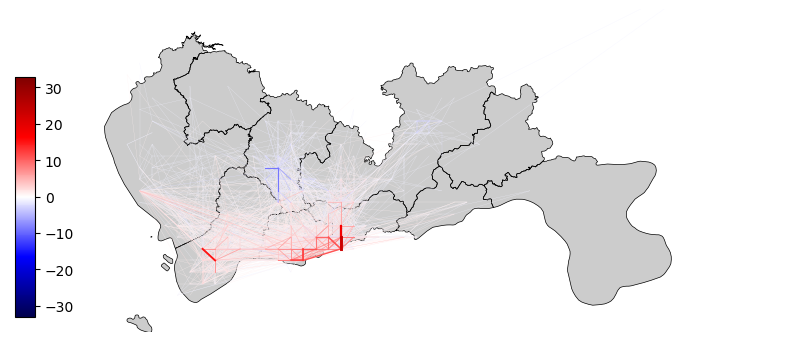

In [53]:
fig     = plt.figure(1,(10,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
bounds = [113.6,22.4,114.8,22.9]

#绘制地图底图
#农村网太慢了，还是暂时别画底图了
#print('绘制地图底图')
#import plot_map
#plot_map.plot_map(plt,bounds,zoom = 12,style = 4)



#绘制行政区划
shp = r'shapefile/sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)

#设定colormap
import matplotlib as mpl
vmax = max(allod['count'].max(),-allod['count'].min())
norm = mpl.colors.Normalize(vmin=-vmax,vmax=vmax)
cmapname = 'seismic'
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
print('绘制OD')
import time
starttime = time.time()
for i in range(len(allod)):
    #设定plt.plot里面的参数alpha和color和linewidth
    color_i=cmap(norm(allod['count'].iloc[i]))
    linewidth_i=3*max(0.05,allod['alpha'].iloc[i])
    plt.plot([allod['SHBLON'].iloc[i],allod['EHBLON'].iloc[i]],
             [allod['SHBLAT'].iloc[i],allod['EHBLAT'].iloc[i]],
             color=color_i,linewidth=linewidth_i)
endtime = time.time()
print('OD绘制时间：',endtime-starttime)
    
#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar
plt.imshow([[-vmax,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)

#把镜头调整回到深圳
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()

如果用geopandas的GeoDataFrame绘制，速度会不会快一点呢

In [54]:
from shapely.geometry import LineString
import geopandas
#生成GeoDataFrame
odgpd = geopandas.GeoDataFrame()
odgpd['alpha'] = allod['alpha']
odgpd['count'] = allod['count']
odgpd['geometry'] = allod.apply(lambda r:LineString([[r['SHBLON'],r['SHBLAT']],[r['EHBLON'],r['EHBLAT']]]),axis = 1)
#将最小的线粗细定义为0.05
odgpd.loc[odgpd['alpha']<0.05,'alpha'] = 0.05
odgpd.head(5)

,alpha,count,geometry
1040,0.05,0.0,LINESTRING (114.0540420735309 22.6187079978440...
145,0.05,0.0,LINESTRING (113.8981184226762 22.5107894728899...
299,0.05,0.0,LINESTRING (113.9176088790331 22.5467623145413...
436,0.05,0.0,LINESTRING (113.9565897917467 22.5287758937156...
741,0.05,0.0,LINESTRING (114.034551617174 22.51078947288992...


绘制OD
OD绘制时间： 0.1456606388092041


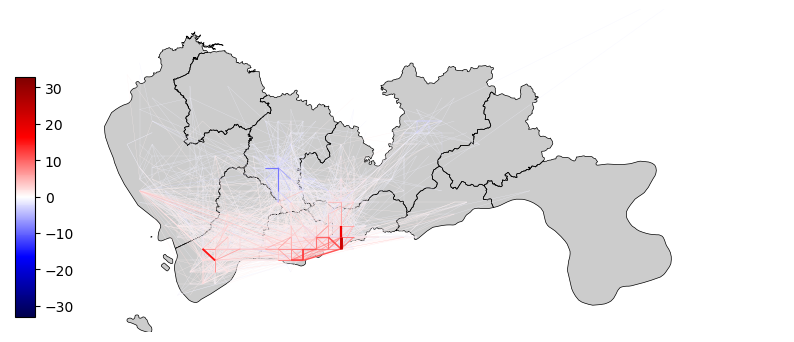

In [55]:
fig     = plt.figure(1,(10,8),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
bounds = [113.6,22.4,114.8,22.9]

#绘制地图底图
#农村网太慢了，还是暂时别画底图了
#print('绘制地图底图')
#import plot_map
#plot_map.plot_map(plt,bounds,zoom = 12,style = 4)


#绘制行政区划
shp = r'shapefile/sz.shp'
xzqh = geopandas.GeoDataFrame.from_file(shp,encoding = 'utf-8')
xzqh.plot(ax = ax,edgecolor = (0,0,0,1),facecolor = (0,0,0,0.2),linewidths=0.5)

#设定colormap
import matplotlib as mpl
vmax = max(allod['count'].max(),-allod['count'].min())
norm = mpl.colors.Normalize(vmin=-vmax,vmax=vmax)
cmapname = 'seismic'
cmap = matplotlib.cm.get_cmap(cmapname)

#绘制OD
print('绘制OD')
import time
starttime = time.time()
odgpd.plot(ax = ax,column = 'count',vmax = vmax,vmin = -vmax,cmap = cmap,linewidth = 3*odgpd['alpha'])
endtime = time.time()
print('OD绘制时间：',endtime-starttime)
    
#不显示坐标轴
plt.axis('off')    

#绘制假的colorbar
plt.imshow([[-vmax,vmax]], cmap=cmap)
cax = plt.axes([0.13, 0.32, 0.02, 0.3])
plt.colorbar(cax=cax)

#把镜头调整回到深圳
ax.set_xlim(113.6,114.8)
ax.set_ylim(22.4,22.9)

plt.show()

geopandas的绘图速度，快了30多倍。此时我哭了，为我逝去的青春而哭

### 高收入车手策略总结
从上面的分析来看，高收入群体确实存在高收入的秘诀，总结一下，那就是：  

>1.勤奋，你需要比别人更勤奋，每天跑更多的路程，接更多的单  
2.选择性接单（拒载），你需要比别人接更多的短距离出行订单（高收入者接的订单平均出行距离比中收入者短！）  
3.工作时间，高收入者在夜间、凌晨的订单比例比中收入者更高，半夜开车挣钱多！  
4.技术，你需要懂得怎么挣钱，在控制自己的空载行驶路程与别人持平的同时，增加自己载客的行驶路程  
5.接客地点，尽量在市中心

## 进一步分析

出租车开车分为载客状态和空载状态，这里提出一个假设：  
>一个出租车手的技术体现(收入差距)不在于载客状态，而在于空载状态

提出这个假设的理由是：载客状态中，都是把客从起点接到终点，出租车接到客后无法改变客人的终点  
而空载状态时，出租车怎么开，下个点去哪里接客，完全是由车手控制的  
>会不会优雅的出租车手，在空载的时候有着与不优雅的车手不同的策略？  


### 空载时候的候车时间有没有差别？

前面的计算，我们知道了高收入出租车手每天的订单数量多，而每天的空载里程则跟中等收入的选手差距不大  
这里小旭学长产生了一个疑问，为什么呢？  
高收入的订单多，中收入订单少，那么高收入空载时间应该比较少，空载行驶的里程应该会比中收入的少才对
>会不会是因为：  
中等收入的空载的时候在原地等的时间比较多？  

好的，马上开始验证我的猜想

这里又涉及到一个问题，出租车车手是需要休息的，比较长的休息时间我们不想计入变成停车时间。  
因此这里要筛去停车时间大于某个值的数据。  
比如说：  
>如果停车了五六个小时，那应该是出租车司机大概这个期间不是工作时间  
如果停车了半小时，那可能出租车司机只是去拉了个屎？  
如果停车了五分钟，那可能出租车司机只是等红灯，也可能是堵车？  

In [56]:
#读取原始数据
data = pd.read_csv(r'data-sample/TaxiData-Sample',header = None)
#给数据命名列
data.columns = ['VehicleNum', 'Stime', 'Lng', 'Lat', 'OpenStatus', 'Speed']

data = data.sort_values(by = ['VehicleNum', 'Stime'])

#将时间字符串转换为pd的时间格式，后面可以轻松的做加减
data['Stime'] = pd.to_datetime(data['Stime'])

########清洗OpenStatus异常的数据#########
print('清洗OpenStatus异常的数据前',len(data))
data = data[-((data['OpenStatus'].shift(-1) == data['OpenStatus'].shift())&
(data['OpenStatus'].shift(-1) != data['OpenStatus'])&
(data['VehicleNum'].shift(-1) == data['VehicleNum'].shift())&
(data['VehicleNum'].shift(-1) == data['VehicleNum']))]
print('清洗OpenStatus异常的数据后',len(data))
#######################################

#定义计算路径长度
data['Lng1'] = data['Lng'].shift(-1)
data['Lat1'] = data['Lat'].shift(-1)



#计算每个点与下一个点的距离
lon1 = data['Lng']
lat1 = data['Lat']
lon2 = data['Lng1']
lat2 = data['Lat1']
data['distance'] = getdistance(lon1, lat1, lon2, lat2)
#判断静止的数据
data['isstop'] = data['distance'] == 0
#删除前一条数据也是静止，这一条数据也是静止的数据
data = data[-((data['isstop']==True) & (data['isstop'].shift()==True))]


data['Stime1'] = data['Stime'].shift(-1)
data['VehicleNum1'] = data['VehicleNum'].shift(-1)

#计算每个点与下一个点的时间差
data['interval'] = (data['Stime1']-data['Stime']).apply(lambda r:r.seconds)

#速度
data['speed'] = (data['distance']/data['interval'])*3.6

data = data[data['VehicleNum1'] == data['VehicleNum']]

data.head(5)

清洗OpenStatus异常的数据前 1601307
清洗OpenStatus异常的数据后 1598866


,VehicleNum,Stime,Lng,Lat,OpenStatus,Speed,Lng1,Lat1,distance,isstop,Stime1,VehicleNum1,interval,speed
39,22271,2020-03-24 00:00:49,114.266502,22.728201,0,0,114.266502,22.728201,0.000000,True,2020-03-24 00:03:46,22271.0,177.0,0.000000
244,22271,2020-03-24 00:03:46,114.266502,22.728201,0,0,114.268898,22.729500,285.041324,False,2020-03-24 00:04:45,22271.0,59.0,17.392352
247,22271,2020-03-24 00:04:45,114.268898,22.729500,0,11,114.272003,22.731199,370.267635,False,2020-03-24 00:05:44,22271.0,59.0,22.592601
468,22271,2020-03-24 00:05:44,114.272003,22.731199,0,18,114.277298,22.731300,543.161449,False,2020-03-24 00:06:42,22271.0,58.0,33.713469
1048,22271,2020-03-24 00:06:42,114.277298,22.731300,0,21,114.282700,22.727800,677.058015,False,2020-03-24 00:07:41,22271.0,59.0,41.312014


看一下出租车停车时间的分布

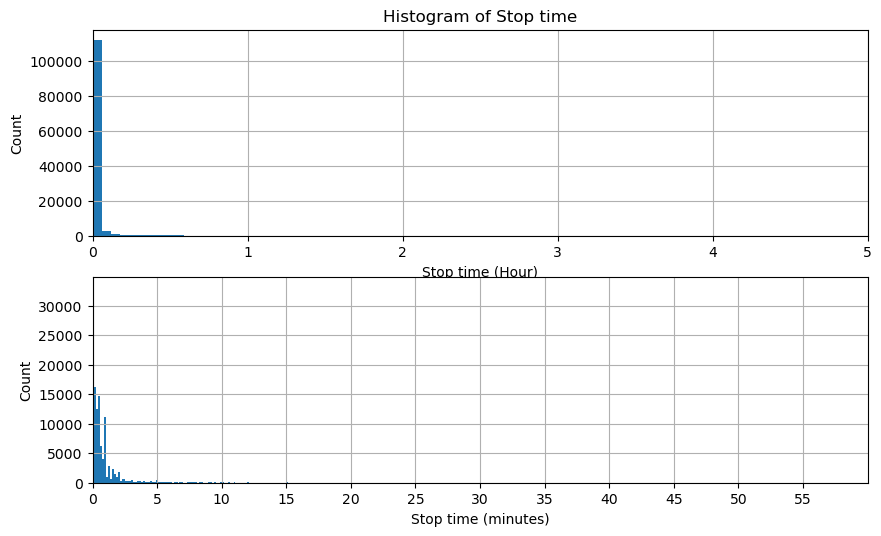

In [57]:
intervaldata = data[data['distance']==0]['interval']/3600

#用pandas自带hist绘制直方图
import matplotlib.pyplot as plt
fig     = plt.figure(1,(10,6),dpi = 100)    
ax1      = plt.subplot(211)
plt.sca(ax1)
intervaldata.hist(ax = ax1,bins = 400)
plt.ylabel('Count')
plt.xlabel('Stop time (Hour)')
plt.xticks(range(24),range(24))
plt.title('Histogram of Stop time')
plt.xlim(0,5)

ax1      = plt.subplot(212)
plt.sca(ax1)
(intervaldata[intervaldata<1]*60).hist(ax = ax1,bins = 400)
plt.ylabel('Count')
plt.xlabel('Stop time (minutes)')
plt.xticks(range(0,60,5),range(0,60,5))
plt.xlim(0,60)
plt.show()

停车时间绝大部分都是非常短的，在这里，我们删去30分钟以上的停车，把摸鱼时间排除，再进行统计

In [58]:
#删掉30分钟以上的停车
data = data[-((data['distance']==0)&(data['interval']>=1800))]

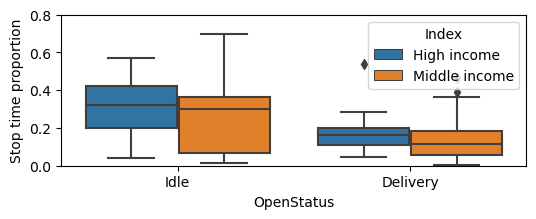

In [59]:
#高收入数据和中收入数据打上标签后合并在一起处理
highincome_data = pd.merge(data,highincome,on = 'VehicleNum')
highincome_data['Index'] = 'High income'
highincome_data['isstop'] = highincome_data['distance']==0
midincome_data = pd.merge(data,midincome,on = 'VehicleNum')
midincome_data['Index'] = 'Middle income'
midincome_data['isstop'] = midincome_data['distance']==0

#计算停车时间占运营时间的比例
tmp1 = pd.concat([midincome_data,highincome_data]).groupby(['isstop','VehicleNum','OpenStatus','Index'])['interval'].sum().reset_index()
tmp1 = pd.merge(tmp1[tmp1['isstop']],tmp1[-tmp1['isstop']],on = ['VehicleNum','OpenStatus','Index'])
tmp1['rate'] = tmp1['interval_x']/(tmp1['interval_x']+tmp1['interval_y'])

#绘图
fig     = plt.figure(1,(6,2),dpi = 100)    
ax      = plt.subplot(111)
plt.sca(ax)
sns.boxplot(x="OpenStatus", y="rate",hue="Index", data=tmp1,hue_order=['High income','Middle income']
,ax = ax)
plt.ylabel('Stop time proportion')
plt.xticks([0,1],['Idle','Delivery'])
plt.ylim(0,0.8)
plt.show()

数据显示的与先前的猜测正好相反，高收入在空载时和载客时的停车时间比例都要比中等收入的高，可能的原因是
>空载时多停车，减少油耗  
载客时多停车，增加候时费